<a href="https://colab.research.google.com/github/KevinHern/SemOpLabs/blob/master/Lab07/Laboratorio7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only works in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from google.colab.patches import cv2_imshow

In [0]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2

# Model Autoencoder Definition

In [0]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64 ,128), latentDim=32):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs

        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=1, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        print("volumeSize:",volumeSize)
        x = Flatten()(x)
        print("x shape", K.int_shape(x))
        latent = Dense(latentDim)(x)

        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")

        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        print("prod shape:",np.prod(volumeSize[1:]))
        print("x shape",K.int_shape(x))
        print(volumeSize)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        print("x shape",K.int_shape(x))

        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (1, 1), strides=1,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")

        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

# Dataset

## Useful Functions

In [0]:
def build_unsupervised_dataset(data, labels, validLabel=4,
    anomalyLabel=8, contam=0.01, seed=42):
    # grab all indexes of the supplied class label that are *truly*
    # that particular label, then grab the indexes of the image
    # labels that will serve as our "anomalies"
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]

    # randomly shuffle both sets of indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)

    # compute the total number of anomaly data points to select
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]

    # use NumPy array indexing to extract both the valid images and
    # "anomlay" images
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]

    # stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)

    # return the set of images
    return images

In [0]:
def visualize_predictions(decoded, gt, samples=10):
    # initialize our list of output images
    outputs = None

    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
    return outputs

## Loading Dataset

In [7]:
# load the Fashion MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=4,
    anomalyLabel=8, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

[INFO] loading MNIST dataset...
4423680/4422102 [==============================] - 0s 0us/step
[INFO] creating unsupervised dataset...


## Train and Test sets

In [0]:
# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
    random_state=42)

# Model

## Macro Variables

In [0]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

## Definition

In [10]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...
volumeSize: (None, 28, 28, 128)
x shape (None, 100352)
prod shape: 100352
x shape (None, 100352)
(None, 28, 28, 128)
x shape (None, 28, 28, 128)


## Training

In [11]:
trainX.shape

(4848, 28, 28, 1)

## Callbacks

In [0]:
#Stop training model when accuracy is bigger than 0.9
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.035):
      self.model.stop_training = True
      
callbacks = Callback()

In [13]:
# train the convolutional autoencoder
H = autoencoder.fit(
    trainX, trainX,
    validation_data=(testX, testX),
    epochs=EPOCHS,
    batch_size=BS)

Train on 4848 samples, validate on 1212 samples
Epoch 1/20
4848/4848 [==============================] - 101s 21ms/sample - loss: 0.0285 - val_loss: 0.1114
Epoch 2/20
4848/4848 [==============================] - 99s 20ms/sample - loss: 0.0126 - val_loss: 0.0815
Epoch 3/20
4848/4848 [==============================] - 98s 20ms/sample - loss: 0.0097 - val_loss: 0.0330
Epoch 4/20
4848/4848 [==============================] - 97s 20ms/sample - loss: 0.0081 - val_loss: 0.0102
Epoch 5/20
4848/4848 [==============================] - 97s 20ms/sample - loss: 0.0071 - val_loss: 0.0073
Epoch 6/20
4848/4848 [==============================] - 97s 20ms/sample - loss: 0.0065 - val_loss: 0.0074
Epoch 7/20
4848/4848 [==============================] - 96s 20ms/sample - loss: 0.0061 - val_loss: 0.0070
Epoch 8/20
4848/4848 [==============================] - 96s 20ms/sample - loss: 0.0058 - val_loss: 0.0071
Epoch 9/20
4848/4848 [==============================] - 96s 20ms/sample - loss: 0.0052 - val_loss: 0.00

## Testing

In [0]:
# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)

In [15]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

# initialize the outputs array
outputs = None

[INFO] mse threshold: 0.04124371581152002
[INFO] 7 outliers found


In [0]:
# loop over the indexes of images with a high mean squared error term
for i in idxs:
    # grab the original image and reconstructed image
    original = (images[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

    # if the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output

    # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])



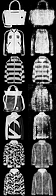

In [17]:
# show the output visualization
cv2_imshow(outputs)